In [1]:
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement

import cv2
import logging
import time

In [2]:
import sys
sys.path.insert(0, '..')

from web_interaction.main import open_game, start_game, wait_loading
from web_interaction.main import fill_game_main_info_from_image
from web_interaction.main import apply_decompose_action, apply_user_story_action
from game.game import ProductOwnerGame
from environment.backlog_env import BacklogEnv
from environment.environment import ProductOwnerEnv
from environment.reward_sytem.base_reward_system import BaseRewardSystem
from environment.userstory_env import UserstoryEnv

from pipeline.study_agent import load_dqn_agent

from web_interaction import GameImageParser, GameCoordinator, WebController

In [3]:
logger = logging.getLogger('WebInteraction')
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(logging.Formatter("%(asctime)s %(message)s"))
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

image_parser = GameImageParser('../web_interaction/templates')
game_coordinator = GameCoordinator(image_parser)
game = ProductOwnerGame()

userstory_env = UserstoryEnv(4, 0, 0)
backlog_env = BacklogEnv(12, 0, 0, 0, 0, 0)
reward_system = BaseRewardSystem(config={})
env = ProductOwnerEnv(userstory_env, backlog_env, with_info=True, reward_system=reward_system)
env.game = game

web_controller = WebController(game_coordinator, logger)

In [4]:
agent = load_dqn_agent('../models/credit_start_model.pt')

In [5]:
driver = open_game()

iframe = driver.find_element(by=By.ID, value='game_drop')

# open full screen
fullscreen_button = driver.find_element(by=By.CLASS_NAME, value="fullscreen_btn")
fullscreen_button.click()

height = iframe.rect["height"]  # 540 or 1028
width = iframe.rect["width"]  # 960 or 1920

wait_loading(iframe)

start_game(driver, iframe)

iframe.screenshot('game_state.png')

image = cv2.imread('game_state.png')

Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event): operation timed out


In [6]:
game_coordinator.skip_tutorial(game)
game_coordinator.insert_user_stories_from_image(game, image)

game.userstories.stories_list

[UserStoryCard(S, loyalty=0.055, customers=3.0]

In [21]:
image_parser.templates = image_parser._load_templates()

In [7]:
game_coordinator.update_header_info(game, image)

print('Sprint', game.context.current_sprint)
print('Money', game.context.get_money())
print('Loyalty', game.context.get_loyalty())
print('Customers', game.context.customers)
print('Credit', game.context.credit)

Sprint 4
Money 33000.0
Loyalty 4.0
Customers 25.0
Credit 300000


In [8]:
from web_interaction.main import (
    apply_start_sprint_action,
    apply_release_action,
    apply_buy_statistical_research_action,
    apply_backlog_card_action
)


def apply_web_action(action: int, driver, iframe: WebElement, env: ProductOwnerEnv):
    if action == 0:  # start sprint

        apply_start_sprint_action(driver, iframe, width, height, env)

        return

    if action == 1:  # decompose

        apply_decompose_action(driver, iframe, width, height, env)

        return

    if action == 2:  # release

        apply_release_action(driver, iframe, width, height, env)

        return

    if action == 5:  # buy statistical research

        apply_buy_statistical_research_action(driver, iframe, env)

        return

    if action >= env.meta_action_dim:

        action -= env.meta_action_dim

    if action < env.userstory_env.max_action_num:
        web_controller.apply_user_story_action(action, driver, iframe, env)
        return

    action -= env.userstory_env.max_action_num

    if action < env.backlog_env.backlog_max_action_num:

        apply_backlog_card_action(action, driver, iframe, env)

        return

    raise Exception(f"Unknown action: {action}")

In [9]:
while not game.context.done:
    state = env.recalculate_state()
    # print(state)

    info = env.get_info()
    # print(info)

    action = agent.get_action(state, info)
    # print(action)

    time.sleep(1)
    apply_web_action(action, driver, iframe, env)

    if env.game.context.current_sprint >= 35:
        break

--- Logging error ---
Traceback (most recent call last):
  File "c:\Program Files\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Program Files\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Program Files\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Program Files\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\krutovskii\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\krutovskii\AppDa

TypeError: cannot unpack non-iterable UserStoryImageInfo object

Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint


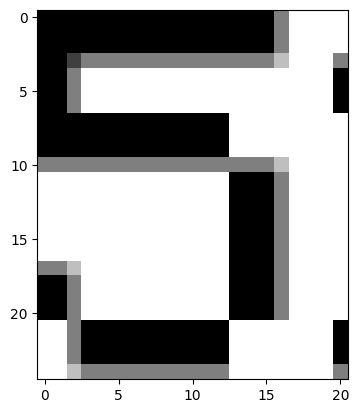

KeyboardInterrupt: Interrupted by user

In [16]:
while not game.context.done:
    time.sleep(1)
    apply_web_action(0, driver, iframe, env)

In [ ]:
iframe.rect

In [ ]:
raise Exception('Break before web driver exit')

In [10]:
driver.quit()